# Faster R-CNN Model Training

***Converting the Dataset to TensorFlow Dataset***

In [1]:
# Imports 
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from pycocotools.coco import COCO
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch.optim as optim

***Tensor Dataset***

In [2]:
# Define the COCO dataset class
class COCODataset(Dataset):
    def __init__(self, annotation_file, image_dir, transforms=None):
        self.coco = COCO(annotation_file)
        self.image_dir = image_dir
        self.transforms = transforms
        self.ids = list(self.coco.imgs.keys())

    def __getitem__(self, index):
        coco = self.coco
        img_id = self.ids[index]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        anns = coco.loadAnns(ann_ids)
        image_info = coco.loadImgs(img_id)[0]
        path = image_info['file_name']

        img = cv2.imread(os.path.join(self.image_dir, path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        num_objs = len(anns)
        boxes = []
        labels = []
        for i in range(num_objs):
            xmin = anns[i]['bbox'][0]
            ymin = anns[i]['bbox'][1]
            xmax = xmin + anns[i]['bbox'][2]
            ymax = ymin + anns[i]['bbox'][3]
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(anns[i]['category_id'])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        if boxes.ndim == 1:
            boxes = boxes.unsqueeze(0)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        image_id = torch.tensor([img_id])
        
        if boxes.size(0) > 0:  # Check if there are any boxes
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        else:
            printf("Image without labels {path}")
            area = torch.tensor([], dtype=torch.float32)

        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.ids)

In [3]:
# Function to find images without annotations
def find_images_without_annotations(annotation_file):
    coco = COCO(annotation_file)
    image_ids = coco.getImgIds()
    images_without_annotations = []
    
    for img_id in image_ids:
        ann_ids = coco.getAnnIds(imgIds=img_id)
        if len(ann_ids) == 0:
            image_info = coco.loadImgs(img_id)[0]
            images_without_annotations.append(image_info['file_name'])
    
    return images_without_annotations

# Path to your annotation file and image directory
annotation_file = '../DataSetup/resized_annotations/annotations_train.json'
image_dir = '../DataSetup/resized_dataset/Train'

# Find images with no annotations
images_without_annotations = find_images_without_annotations(annotation_file)

# Print the results
print(f"Found {len(images_without_annotations)} images without annotations:")
for img_name in images_without_annotations:
    print(img_name)

# Delete images and update annotations
def delete_images_and_update_annotations(annotation_file, image_dir, images_without_annotations):
    # Load the annotation file
    with open(annotation_file, 'r') as f:
        annotations = json.load(f)
    
    # Filter out images without annotations
    annotations['images'] = [img for img in annotations['images'] if img['file_name'] not in images_without_annotations]
    annotation_img_ids = set(img['id'] for img in annotations['images'])
    
    # Filter out annotations of removed images
    annotations['annotations'] = [ann for ann in annotations['annotations'] if ann['image_id'] in annotation_img_ids]
    
    # Save the updated annotation file
    with open(annotation_file, 'w') as f:
        json.dump(annotations, f)
    
    # Delete image files without annotations
    for img_name in images_without_annotations:
        img_path = os.path.join(image_dir, img_name)
        if os.path.exists(img_path):
            os.remove(img_path)
            print(f"Deleted {img_path}")

# Delete images and update annotations
delete_images_and_update_annotations(annotation_file, image_dir, images_without_annotations)



loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Found 0 images without annotations:


In [4]:
# Define transforms
transform = transforms.Compose([transforms.ToTensor()])

# Initialize dataset and dataloader
annotation_file = '../DataSetup/resized_annotations/annotations_train.json'
image_dir = '../DataSetup/resized_dataset/Train'
dataset = COCODataset(annotation_file, image_dir, transforms=transform)

def collate_fn(batch):
    batch = [b for b in batch if b is not None]  # Filter out None entries
    return tuple(zip(*batch))

dataloader = DataLoader(
    dataset,
    batch_size=4,
    shuffle=True,
    num_workers=4,
    drop_last=True,
    collate_fn=collate_fn
)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


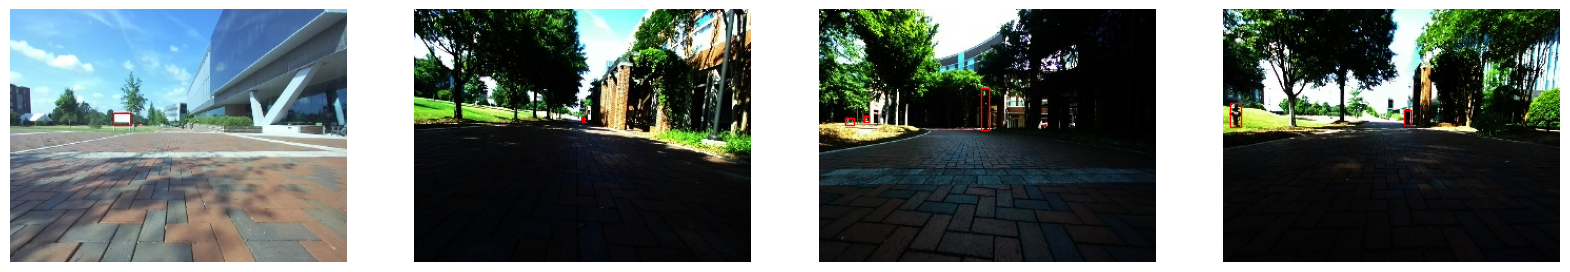

In [16]:
# Function to visualize a batch of images
def visualize_batch(images, targets):
    fig, axes = plt.subplots(1, len(images), figsize=(20, 5))
    for i, (img, target) in enumerate(zip(images, targets)):
        img = img.permute(1, 2, 0).numpy()  # Convert tensor to numpy array
        img = (img * 255).astype(np.uint8)  # Convert to uint8
        axes[i].imshow(img)
        boxes = target['boxes'].numpy()
        for box in boxes:
            xmin, ymin, xmax, ymax = box
            rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color='red')
            axes[i].add_patch(rect)
        axes[i].axis('off')
    plt.show()

# Get a batch of data
images, targets = next(iter(dataloader))

# Visualize the batch
visualize_batch(images, targets)

In [17]:
# Load a pre-trained model for classification and return only the features
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1)

# Get the number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# Replace the pre-trained head with a new one
num_classes = len(dataset.coco.getCatIds()) + 1  # COCO class IDs + background class
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Move the model to the right device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [20]:
num_epochs = 10
learning_rate = 0.005
model_save_path = "model.pt"
# Define the optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=learning_rate, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Training loop
for epoch in range(num_epochs):
    model.train()
    print(f"Starting epoch {epoch + 1}/{num_epochs}")
    i = 0
    for images, targets in dataloader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass
        losses.backward()
        optimizer.step()

        if i % 10 == 0:
            print(f"Epoch: {epoch + 1}/{num_epochs}, Iteration: {i}, Loss: {losses.item():.4f}")
        i += 1

    # Update the learning rate
    lr_scheduler.step()
    print(f"Finished epoch {epoch + 1}/{num_epochs}, Loss: {losses.item():.4f}")
    # Save the model at the end of each epoch
    torch.save(model.state_dict(), f"model_epoch_{epoch + 1}.pth")
    print(f"Finished epoch {epoch + 1}/{num_epochs}, Loss: {losses.item():.4f}")

# Save the final model
torch.save(model.state_dict(), model_save_path)
print("Training complete. Model saved.")
print("Training complete.")

Starting epoch 1/10
Epoch: 1/10, Iteration: 0, Loss: 0.0544
Epoch: 1/10, Iteration: 10, Loss: 0.0360
Epoch: 1/10, Iteration: 20, Loss: 0.0915
Epoch: 1/10, Iteration: 30, Loss: 0.0566
Epoch: 1/10, Iteration: 40, Loss: 0.2149
Epoch: 1/10, Iteration: 50, Loss: 0.1088
Epoch: 1/10, Iteration: 60, Loss: 0.0619
Finished epoch 1/10, Loss: 0.0997
Finished epoch 1/10, Loss: 0.0997
Starting epoch 2/10
Epoch: 2/10, Iteration: 0, Loss: 0.0613
Epoch: 2/10, Iteration: 10, Loss: 0.1690
Epoch: 2/10, Iteration: 20, Loss: 0.0397
Epoch: 2/10, Iteration: 30, Loss: 0.1539
Epoch: 2/10, Iteration: 40, Loss: 0.1638
Epoch: 2/10, Iteration: 50, Loss: 0.1271
Epoch: 2/10, Iteration: 60, Loss: 0.1110
Finished epoch 2/10, Loss: 0.0623
Finished epoch 2/10, Loss: 0.0623
Starting epoch 3/10
Epoch: 3/10, Iteration: 0, Loss: 0.1837
Epoch: 3/10, Iteration: 10, Loss: 0.1338
Epoch: 3/10, Iteration: 20, Loss: 0.0783
Epoch: 3/10, Iteration: 30, Loss: 0.1089
Epoch: 3/10, Iteration: 40, Loss: 0.0956
Epoch: 3/10, Iteration: 50, 

In [22]:
# Load the model 
model.load_state_dict(torch.load(model_save_path))
model.eval()



FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

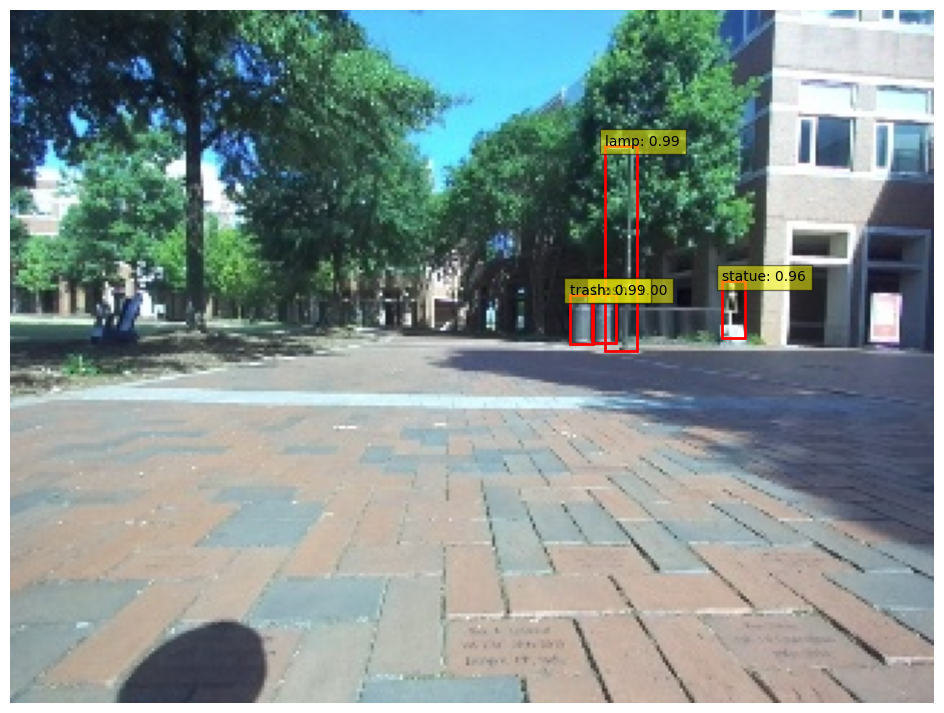

In [33]:
from PIL import Image
import matplotlib.patches as patches  # Ensure patches is imported
# Define the transformation to match the training preprocessing
transform = transforms.Compose([
    # transforms.Resize((320, 240)),  # Resize to (320, 240)
    transforms.ToTensor(),  
])

def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = transform(image)
    return image.unsqueeze(0) 

# Load and preprocess the test image
# test_image_path = '09_52_52.jpg' 
test_image_path = '../DataSetup/resized_dataset/Train/09_51_08.jpg'
test_image = load_image(test_image_path).to(device)

# Disable gradient calculation for inference
with torch.no_grad():
    prediction = model(test_image)

label_class = ["trash", "lamp", "fire hydrant", "board", "statue"]

def visualize_predictions(image, prediction, threshold=0.5):
    # Convert the tensor image to a NumPy array and transpose the dimensions
    image = image.squeeze().permute(1, 2, 0).cpu().numpy()

    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(image)

    boxes = prediction[0]['boxes'].cpu().numpy()
    scores = prediction[0]['scores'].cpu().numpy()
    labels = prediction[0]['labels'].cpu().numpy()

    for box, score, label in zip(boxes, scores, labels):
        if score >= threshold:
            xmin, ymin, xmax, ymax = box
            rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.text(xmin, ymin, f'{label_class[label - 1]}: {score:.2f}', bbox=dict(facecolor='yellow', alpha=0.5))

    plt.axis('off')
    plt.show()


visualize_predictions(test_image, prediction)